In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
from ray import tune
import numpy as np
import math

c:\Users\kwitv\Documents\MARC\Range-Estimation-MARC\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import data from Data/phil_socdata_train.csv, normalize (between 0 and 1) and standardize
train_data = TabularDataset('Data/phil_socdata_train.csv')

# drop the "T" column as it doesnt help with the prediction
train_data = train_data.drop(labels=['T'],axis=1)
train_data.head()


,SOC,V,I,P,V_avg,I_avg
0,100.000031,400.75,0.000000,0.000000,400.75,0.000000
1,100.000031,400.75,-0.270000,-108.202337,400.75,-0.135000
2,100.000031,400.75,-0.539999,-216.404674,400.75,-0.270000
3,100.000031,400.75,-0.809999,-324.607010,400.75,-0.404999
4,100.000031,400.75,-1.079998,-432.809347,400.75,-0.539999


<Axes: >

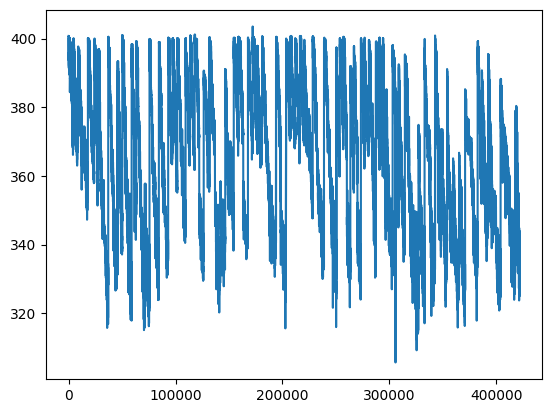

In [3]:
#plots V in the training data
train_data['V'].plot()


In [4]:
label = 'SOC'
train_data[label].describe()

count    421697.000000
mean         68.185519
std          24.502969
min           0.000000
25%          49.019623
50%          73.333359
75%          89.019638
max         100.000031
Name: SOC, dtype: float64

In [5]:
time_limit = 60  # train various models for x minutes

predictor = TabularPredictor(label=label).fit(
    train_data, 
    time_limit=time_limit, 
    presets='best_quality'
)



No path specified. Models will be saved in: "AutogluonModels\ag-20230420_142527\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels\ag-20230420_142527\"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Train Data Rows:    421697
Train Data Columns: 5
Label Column: SOC
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (100.000030517578, 0.0, 68.18552, 24.50297)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Gener

In [6]:
# import test data from Data/phil_socdata_test.csv, normalize (between 0 and 1) and standardize
test_data1 = TabularDataset(f'Data/phil_socdata_test1.csv')
test_data2 = TabularDataset(f'Data/phil_socdata_test2.csv')

y_pred1= predictor.predict(test_data1.drop(columns=[label]))
y_pred1.head()

y_pred2= predictor.predict(test_data2.drop(columns=[label]))
y_pred2.head()

Loaded data from: Data/phil_socdata_test1.csv | Columns = 7 / 7 | Rows = 18307 -> 18307
Loaded data from: Data/phil_socdata_test2.csv | Columns = 7 / 7 | Rows = 5617 -> 5617


0    53.823978
1    52.944302
2    52.948433
3    53.094688
4    53.096321
Name: SOC, dtype: float32

In [7]:
predictor.evaluate(test_data1, silent=True)

c:\Users\kwitv\Documents\MARC\Range-Estimation-MARC\venv\lib\site-packages\autogluon\tabular\predictor\predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -2.1604760649039982,
 'mean_squared_error': -4.667656827023065,
 'mean_absolute_error': -1.683928318813988,
 'r2': 0.992781395239354,
 'pearsonr': 0.9981430226798744,
 'median_absolute_error': -1.300621032011719}

In [8]:
predictor.evaluate(test_data2, silent=True)

c:\Users\kwitv\Documents\MARC\Range-Estimation-MARC\venv\lib\site-packages\autogluon\tabular\predictor\predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -1.208816180006668,
 'mean_squared_error': -1.4612365570459132,
 'mean_absolute_error': -0.937381278554752,
 'r2': 0.99200822543625,
 'pearsonr': 0.996133702163627,
 'median_absolute_error': -0.7591133141601532}

In [9]:
predictor.leaderboard(test_data1, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-2.150676,-2.222207,0.973866,16.016972,21.344382,0.973866,16.016972,21.344382,1,True,2
1,WeightedEnsemble_L2,-2.160476,-2.204917,1.081098,17.588987,26.511069,0.001994,0.008975,4.323821,2,True,3
2,LightGBMXT_BAG_L2,-2.313192,-2.254367,1.325461,20.646791,30.423747,0.246357,3.066779,8.236498,2,True,4
3,WeightedEnsemble_L3,-2.313192,-2.254367,1.327456,20.662746,30.469167,0.001995,0.015955,0.045420,3,True,5
4,KNeighborsDist_BAG_L1,-3.790115,-3.543409,0.105238,1.563040,0.842867,0.105238,1.563040,0.842867,1,True,1


In [10]:
predictor.leaderboard(test_data2, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-1.158523,-2.222207,0.368046,16.016972,21.344382,0.368046,16.016972,21.344382,1,True,2
1,WeightedEnsemble_L2,-1.208816,-2.204917,0.422900,17.588987,26.511069,0.001995,0.008975,4.323821,2,True,3
2,LightGBMXT_BAG_L2,-1.333325,-2.254367,0.527129,20.646791,30.423747,0.106223,3.066779,8.236498,2,True,4
3,WeightedEnsemble_L3,-1.333325,-2.254367,0.529123,20.662746,30.469167,0.001995,0.015955,0.045420,3,True,5
4,KNeighborsDist_BAG_L1,-4.212411,-3.543409,0.052860,1.563040,0.842867,0.052860,1.563040,0.842867,1,True,1


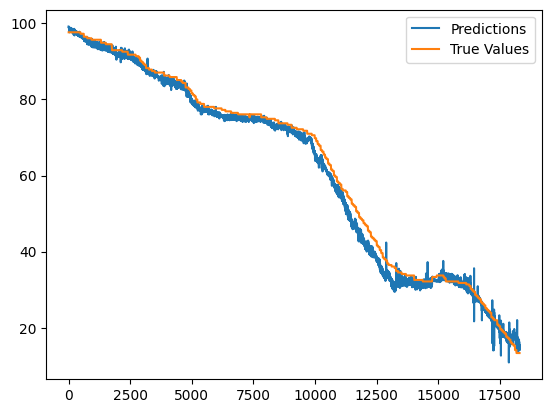

In [11]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred1, label="Predictions")
plt.plot(test_data1[label], label="True Values")
plt.legend()
plt.show()

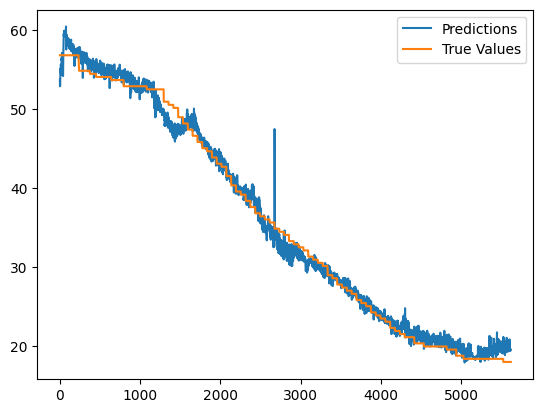

In [12]:
plt.plot(y_pred2, label="Predictions")
plt.plot(test_data2[label], label="True Values")
plt.legend()
plt.show()

In [13]:
mse_test = np.mean(((y_pred1 - test_data1[label])**2))
rmse_test = math.sqrt(mse_test)
print("Test data 1 RMSE", rmse_test)
mse_test = np.mean(((y_pred2 - test_data2[label])**2))
rmse_test = math.sqrt(mse_test)
print("Test data 2 RMSE", rmse_test)

Test data 1 RMSE 2.1604760649039982
Test data 2 RMSE 1.208816180006668


In [14]:
predictor.feature_importance(test_data1)

These features in provided data are not utilized by the predictor and will be ignored: ['T']
Computing feature importance via permutation shuffling for 5 features using 5000 rows with 5 shuffle sets...
	9.98s	= Expected runtime (2.0s per shuffle set)
	8.63s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V,19.696603,0.184323,9.201999e-10,5,20.076126,19.317080
V_avg,15.413170,0.171168,1.824855e-09,5,15.765607,15.060734
I_avg,3.602961,0.071589,1.869411e-08,5,3.750364,3.455558
P,1.262484,0.008102,2.035645e-10,5,1.279167,1.245801
I,0.111797,0.011622,1.381709e-05,5,0.135728,0.087867


In [15]:
predictor.feature_importance(test_data2)

These features in provided data are not utilized by the predictor and will be ignored: ['T']
Computing feature importance via permutation shuffling for 5 features using 5000 rows with 5 shuffle sets...
	10.75s	= Expected runtime (2.15s per shuffle set)
	9.03s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V_avg,9.769836,0.221263,3.154793e-08,5,10.225420,9.314252
V,8.648777,0.169681,1.776931e-08,5,8.998152,8.299402
I_avg,4.321768,0.032510,3.842351e-10,5,4.388708,4.254828
P,2.325155,0.008827,2.492644e-11,5,2.343330,2.306980
I,0.352466,0.009532,6.413142e-08,5,0.372093,0.332839


Exception in thread 2023-04-20 10:39:59,546	ERROR import_thread.py:75 -- ImportThread: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Stream removed"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:63428 {grpc_message:"Stream removed", grpc_status:2, created_time:"2023-04-20T14:39:59.556013748+00:00"}"
>
ray_listen_error_messages:
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\kwitv\Documents\MARC\Range-Estimation-MARC\venv\lib\site-packages\ray\_private\worker.py", line 1836, in listen_error_messages
    _, error_data = worker.gcs_error_subscriber.poll()
  Fi